In [1]:
%matplotlib inline

# An LSTM for Part-of-Speech Tagging
https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [51]:
embedding = nn.Embedding(10, 3, padding_idx=5)

In [53]:
print(embedding(torch.LongTensor([5])))

tensor([[0., 0., 0.]], grad_fn=<EmbeddingBackward>)


### Load Data

In [3]:
path = '../Data/DumaPunct.csv'

In [4]:
import csv
import codecs
i = 0

LoadDataset = []

encoding = 'utf-8'
with codecs.open(path, "r", encoding) as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
   
    data = []
    for row in csv_reader:
        
        if len(row) == 0:
            LoadDataset.append(data)
            data = []
        else:
            word = row[0]
            
            if word == 'intonation':
                tag = int(row[1])
                onerow = (word, tag)
            
            else:
                tag = []
                for i in row[1][1:-2].split('), '):
                    onestr = i[1:].split(', ')
                    tag.append((onestr[0][1:-1], int(onestr[1])))
                
                punct = [int(i) for i in row[2][1:-1].split(', ')]

                onerow = (word, tag, punct)

                
            data.append(onerow)
print('end')

end


## Prepare data!

In [5]:
LoadDataset[0]

[('александр',
  [('subpart_of_speech', 1), ('form', 1), ('genesys', 1), ('semantics1', 10)],
  [0, 0]),
 ('дюма',
  [('subpart_of_speech', 1), ('form', 0), ('genesys', 8), ('semantics1', 20)],
  [0, 1]),
 ('intonation', 11)]

In [6]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

punct_to_ix = { 'nothing': 0,
    '.': 1, ',': 2, ':': 3, ';': 4, '!': 5, '?': 6, '!!!': 7, '???': 8, '!?': 9, '?!': 10,
    '...': 11, '-': 12, '—': 13, ',-': 14, '/': 15, '\\': 16, '|': 17, '\'': 18
}

In [8]:
def addpunct(objec, index):
    if objec[2][index] != 0:
        word = list(punct_to_ix.items())[objec[2][index]][0]
        tag = 'PUNCT'
        return word, tag
    return 0, 'Nothing'

In [9]:
alltags = []

data = []
i = 0
for sentence in LoadDataset:
    sentence_data = []
    words = []
    tags = []
    
    i += 1
    for obj in sentence:
        
        if obj[0] != 'intonation':
            
            w, t = addpunct(obj, 0)
            if t != 'Nothing':

                words.append(w)
                tags.append(0)
                
            words.append(obj[0])
            tags.append(0)
            
            w, t = addpunct(obj, 1)
            if t != 'Nothing':

                words.append(w)
                tags.append(0)
        
        else:
            try:
                tags.pop()
                tags.append(obj[1])
            except IndexError:
                
                print(i, 'pidor')
            alltags.append(obj[1])
    
    if len(words) != 0 and len(tags) != 0:
        sentence_data.append(words)
        sentence_data.append(tags)

        sentence_data = tuple(sentence_data)
        data.append(sentence_data)
    
print('num of sentences:', len(data))

7662 pidor
26360 pidor
num of sentences: 32635


In [10]:
set(alltags)

{11, 30, 40, 50, 70, 110}

In [11]:
tag_to_ix = {
    0: 0, 11: 1, 30: 2, 40: 3, 50: 4, 70: 5, 110: 6
}

# create dicts!
word_to_ix = {}
for sent, tags in data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
                  
print(len(word_to_ix), len(tag_to_ix))

43502 7


In [12]:
data[:5]

[(['александр', 'дюма', '.'], [0, 0, 11]),
 (['граф', 'монтекристо', '.'], [0, 0, 11]),
 (['часть', 'первая', '.'], [0, 0, 11]),
 (['i', '.'], [0, 11]),
 (['марсель', '.'], [0, 11])]

### Train_test split

In [13]:
from sklearn.model_selection import train_test_split
num_of_test = 0.2

train_data, test_data = train_test_split(data, test_size = num_of_test, random_state = 42)
print(len(train_data), len(test_data))

26108 6527


# Train the model:



In [17]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim1, hidden_dim2, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim1.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim1, bidirectional=True)

        self.lstm2 = nn.LSTM(hidden_dim1*2, hidden_dim2, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim2*2, tagset_size)
        self.hidden1 = self.init_hidden1()
        self.hidden2 = self.init_hidden2()

    def init_hidden1(self):

        return (torch.zeros(2, 1, self.hidden_dim1),
                torch.zeros(2, 1, self.hidden_dim1))

    def init_hidden2(self):

        return (torch.zeros(2, 1, self.hidden_dim2),
                torch.zeros(2, 1, self.hidden_dim2))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden1)

        lstm_out2, self.hidden = self.lstm2(
            lstm_out.view(len(sentence), 1, -1), self.hidden2)

        tag_space = self.hidden2tag(lstm_out2.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

## Funcs

In [15]:
def train(sentence, tag):
    model.zero_grad()

    sentence_in = prepare_sequence(sentence, word_to_ix)
    targets = prepare_sequence(tag, tag_to_ix)

    # forward pass
    tag_scores = model(sentence_in)

    # loss and backward
    loss = loss_function(tag_scores, targets)
    #print(tag_scores, targets, loss)
    for i in targets:
        if i == 2 or i == 3 or i == 4:
            loss *= 5
            break
        elif i == 5:
            loss *= 5
            break
            #print(loss)
    
    loss.backward()
    
    loss.detach_()
    
    optimizer.step()
        
    return tag_scores, loss

In [16]:
from sklearn.metrics import accuracy_score

def evaluate(num_iter = 100):
    with torch.no_grad():
        
        main_score = 0
        for i in range(num_iter):
            rng = np.random.randint(len(test_data))

            inputs = prepare_sequence(test_data[rng][0], word_to_ix)
            output = model(inputs)

            # get top
            topv, topi = output.topk(1)
            true_values = prepare_sequence(test_data[rng][1], tag_to_ix)

            score = accuracy_score(true_values, topi)
            main_score += score
        
        return main_score / num_iter

In [18]:
def total_evaluate():
    with torch.no_grad():
        
        main_score = 0
        for i in range(len(test_data)):

            inputs = prepare_sequence(test_data[i][0], word_to_ix)
            output = model(inputs)

            # get top
            topv, topi = output.topk(1)
            true_values = prepare_sequence(test_data[i][1], tag_to_ix)

            score = accuracy_score(true_values, topi)
            main_score += score
        
        return main_score / len(test_data)

In [19]:
def train_rng():
    
    rng = np.random.randint(len(train_data))
    
    sentence = train_data[rng][0]
    tag = train_data[rng][1]
    
    return sentence, tag

In [20]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

## GONNA TRAIN!

# Attention 2-4 + BIG 5

In [36]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

a = classification_report(y_test, y_train, target_names = [str(K) for K in list(tag_to_ix.keys())])

print(a)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    305644
          11       0.99      0.99      0.99     28460
          30       0.87      0.78      0.82      1770
          40       0.95      0.97      0.96      1636
          50       0.88      0.84      0.86       487
          70       0.86      0.83      0.84      2230
         110       0.94      0.91      0.93     36998

   micro avg       0.98      0.98      0.98    377225
   macro avg       0.93      0.90      0.91    377225
weighted avg       0.98      0.98      0.98    377225



In [21]:
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
HIDDEN_DIM2 = 128

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, HIDDEN_DIM2, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()

all_losses = []

In [27]:
learning_rate = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_iters = 7000

plot_every = 100
print_every = 250

current_loss = 0
#all_losses = []

start = time.time()

model.hidden1 = model.init_hidden1()
model.hidden2 = model.init_hidden2()


for i in range(1, n_iters + 1):
    
    se, tag = train_rng()
    out, loss = train(se, tag)
    current_loss += loss
    
    if i % print_every == 0:
        print('%d %d%% (%s) loss: %.4f accuracy on test: %.4f' % (i, i / n_iters * 100, 
                                                                  timeSince(start), loss, evaluate()))

    
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

250 3% (0m 22s) loss: 0.0104 accuracy on test: 0.9823
500 7% (0m 45s) loss: 0.0028 accuracy on test: 0.9744
750 10% (1m 10s) loss: 0.0013 accuracy on test: 0.9905
1000 14% (1m 33s) loss: 0.1971 accuracy on test: 0.9842
1250 17% (1m 56s) loss: 0.0052 accuracy on test: 0.9822
1500 21% (2m 18s) loss: 0.0098 accuracy on test: 0.9835
1750 25% (2m 44s) loss: 0.7189 accuracy on test: 0.9847
2000 28% (3m 8s) loss: 0.0064 accuracy on test: 0.9887
2250 32% (3m 33s) loss: 0.4790 accuracy on test: 0.9846
2500 35% (3m 56s) loss: 0.0064 accuracy on test: 0.9828
2750 39% (4m 20s) loss: 0.2480 accuracy on test: 0.9912
3000 42% (4m 44s) loss: 0.0780 accuracy on test: 0.9871
3250 46% (5m 8s) loss: 0.0039 accuracy on test: 0.9863
3500 50% (5m 31s) loss: 0.0235 accuracy on test: 0.9837
3750 53% (5m 55s) loss: 2.9753 accuracy on test: 0.9839
4000 57% (6m 19s) loss: 0.0352 accuracy on test: 0.9810
4250 60% (6m 42s) loss: 0.0349 accuracy on test: 0.9803
4500 64% (7m 4s) loss: 0.0085 accuracy on test: 0.9885


0.9852290386953263


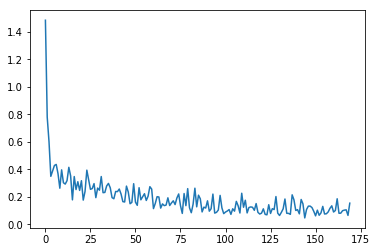

In [28]:
import matplotlib.pyplot as plt

print(total_evaluate())

plt.plot(all_losses)
plt.show()

In [29]:
all_categories = list(tag_to_ix)
n_categories = len(all_categories)

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories) 

y_test = []
y_train = []
with torch.no_grad():
    for i in range(len(test_data)):

        inputs = prepare_sequence(test_data[i][0], word_to_ix)
        output = model(inputs)

        # get top
        topv, topi = output.topk(1)
        true_values = prepare_sequence(test_data[i][1], tag_to_ix)
    
        for j in range(len(true_values)):
            confusion[true_values[j]][topi[j]] += 1 # инк ячейку
            y_train.append(topi[j].item())
            y_test.append(true_values[j].item())
            
normalize_confusion = torch.clone(confusion)
# Normalize 
for i in range(n_categories):
    normalize_confusion[i] = normalize_confusion[i] / normalize_confusion[i].sum()

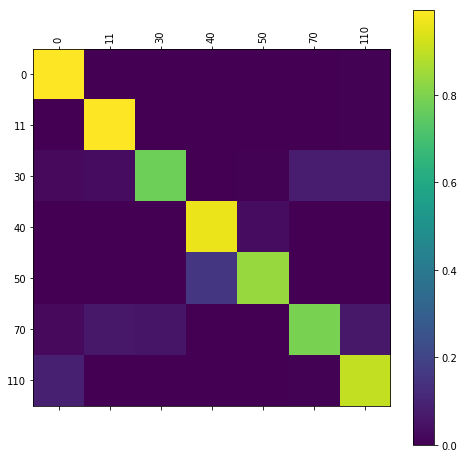

In [30]:
from matplotlib import ticker

# Set up plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(normalize_confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [31]:
# ~7700, ~700, 63, 27, 13, 41, ~900
all_perc = 0
for i in range(n_categories):
    
    percent = normalize_confusion[i][i].item()
    all_perc += percent
    
    print(normalize_confusion[i][i], confusion[i][i])
    
print(all_perc / (n_categories - 1))

tensor(0.9943) tensor(74776.)
tensor(0.9908) tensor(6984.)
tensor(0.7768) tensor(348.)
tensor(0.9660) tensor(369.)
tensor(0.8416) tensor(85.)
tensor(0.7955) tensor(459.)
tensor(0.9020) tensor(8256.)
1.0444865822792053


In [35]:
all_categories = list(tag_to_ix)
n_categories = len(all_categories)

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories) 
y_test = []
y_train = []
with torch.no_grad():
    for i in range(len(train_data)):

        inputs = prepare_sequence(train_data[i][0], word_to_ix)
        output = model(inputs)

        # get top
        topv, topi = output.topk(1)
        true_values = prepare_sequence(train_data[i][1], tag_to_ix)
    
        for j in range(len(true_values)):
            confusion[true_values[j]][topi[j]] += 1 # инк ячейку
            y_train.append(topi[j].item())
            y_test.append(true_values[j].item())            
normalize_confusion = torch.clone(confusion)
# Normalize 
for i in range(n_categories):
    normalize_confusion[i] = normalize_confusion[i] / normalize_confusion[i].sum()

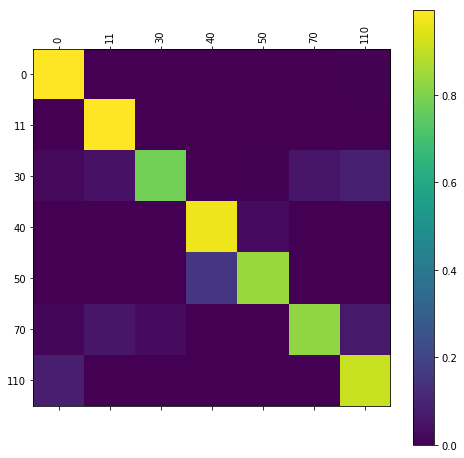

In [33]:
from matplotlib import ticker

# Set up plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(normalize_confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [34]:
# ~7700, ~700, 63, 27, 13, 41, ~900
all_perc = 0
for i in range(n_categories):
    
    percent = normalize_confusion[i][i].item()
    all_perc += percent
    
    print(normalize_confusion[i][i], confusion[i][i])
    
print(all_perc / (n_categories - 1))

tensor(0.9944) tensor(303931.)
tensor(0.9921) tensor(28236.)
tensor(0.7808) tensor(1382.)
tensor(0.9700) tensor(1587.)
tensor(0.8419) tensor(410.)
tensor(0.8283) tensor(1847.)
tensor(0.9094) tensor(33645.)
1.052813063065211


# Attention 2-5

In [86]:
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
HIDDEN_DIM2 = 128

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, HIDDEN_DIM2, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()

all_losses = []

In [87]:
learning_rate = 0.1

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_iters = 8000

plot_every = 100
print_every = 250

current_loss = 0
#all_losses = []

start = time.time()

model.hidden1 = model.init_hidden1()
model.hidden2 = model.init_hidden2()


for i in range(1, n_iters + 1):
    
    se, tag = train_rng()
    out, loss = train(se, tag)
    current_loss += loss
    
    if i % print_every == 0:
        print('%d %d%% (%s) loss: %.4f accuracy on test: %.4f' % (i, i / n_iters * 100, 
                                                                  timeSince(start), loss, evaluate()))

    
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

250 3% (0m 29s) loss: 0.3770 accuracy on test: 0.9048
500 6% (1m 3s) loss: 0.2119 accuracy on test: 0.9597
750 9% (1m 39s) loss: 0.0093 accuracy on test: 0.9532
1000 12% (2m 13s) loss: 0.2857 accuracy on test: 0.9584
1250 15% (2m 46s) loss: 0.4748 accuracy on test: 0.9608
1500 18% (3m 17s) loss: 0.8562 accuracy on test: 0.9646
1750 21% (3m 51s) loss: 0.0501 accuracy on test: 0.9787
2000 25% (4m 23s) loss: 1.1603 accuracy on test: 0.9319
2250 28% (5m 0s) loss: 0.0358 accuracy on test: 0.9227
2500 31% (5m 43s) loss: 0.0762 accuracy on test: 0.9521
2750 34% (6m 22s) loss: 1.4389 accuracy on test: 0.9005
3000 37% (7m 1s) loss: 0.4195 accuracy on test: 0.9575
3250 40% (7m 33s) loss: 0.0035 accuracy on test: 0.9751
3500 43% (8m 7s) loss: 0.1358 accuracy on test: 0.9664
3750 46% (8m 38s) loss: 0.0550 accuracy on test: 0.9679
4000 50% (9m 10s) loss: 3.3848 accuracy on test: 0.9298
4250 53% (9m 42s) loss: 0.0047 accuracy on test: 0.9658
4500 56% (10m 10s) loss: 0.0253 accuracy on test: 0.9673
4

0.9686576025831117


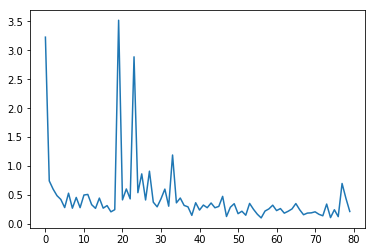

In [88]:
import matplotlib.pyplot as plt

print(total_evaluate())

plt.plot(all_losses)
plt.show()

In [89]:
all_categories = list(tag_to_ix)
n_categories = len(all_categories)

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories) 

with torch.no_grad():
    for i in range(len(test_data)):

        inputs = prepare_sequence(test_data[i][0], word_to_ix)
        output = model(inputs)

        # get top
        topv, topi = output.topk(1)
        true_values = prepare_sequence(test_data[i][1], tag_to_ix)
    
        for j in range(len(true_values)):
            confusion[true_values[j]][topi[j]] += 1 # инк ячейку
            
normalize_confusion = torch.clone(confusion)
# Normalize 
for i in range(n_categories):
    normalize_confusion[i] = normalize_confusion[i] / normalize_confusion[i].sum()

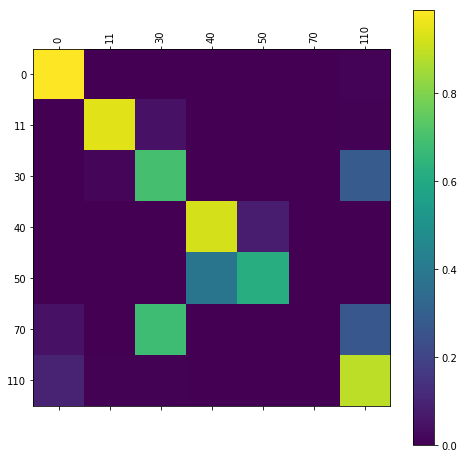

In [90]:
from matplotlib import ticker

# Set up plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(normalize_confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [91]:
# ~7700, ~700, 63, 27, 13, 41, ~900
all_perc = 0
for i in range(n_categories):
    
    percent = normalize_confusion[i][i][0]
    all_perc += percent
    
    print(normalize_confusion[i][i], confusion[i][i])
    
print(all_perc / (n_categories - 1))

tensor(0.9899) tensor(7657.)
tensor(0.9448) tensor(633.)
tensor(0.6984) tensor(44.)
tensor(0.9259) tensor(25.)
tensor(0.6154) tensor(8.)
tensor(0.) tensor(0.)
tensor(0.8897) tensor(774.)
tensor(0.8440)


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [99]:
all_categories = list(tag_to_ix)
n_categories = len(all_categories)

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories) 

with torch.no_grad():
    for i in range(len(train_data)):

        inputs = prepare_sequence(train_data[i][0], word_to_ix)
        output = model(inputs)

        # get top
        topv, topi = output.topk(1)
        true_values = prepare_sequence(train_data[i][1], tag_to_ix)
    
        for j in range(len(true_values)):
            confusion[true_values[j]][topi[j]] += 1 # инк ячейку
            
normalize_confusion = torch.clone(confusion)
# Normalize 
for i in range(n_categories):
    normalize_confusion[i] = normalize_confusion[i] / normalize_confusion[i].sum()

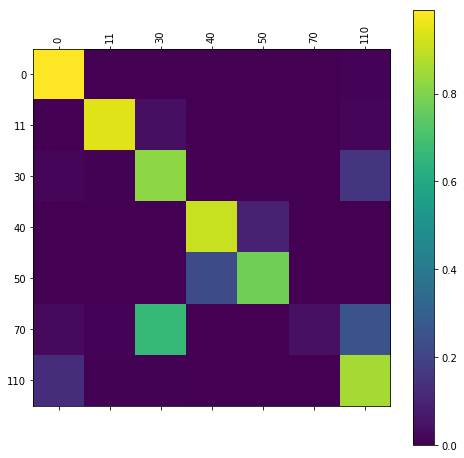

In [100]:
from matplotlib import ticker

# Set up plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(normalize_confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [101]:
# ~7700, ~700, 63, 27, 13, 41, ~900
all_perc = 0
for i in range(n_categories):
    
    percent = normalize_confusion[i][i][0]
    all_perc += percent
    
    print(normalize_confusion[i][i], confusion[i][i])
    
print(all_perc / (n_categories - 1))

tensor(0.9906) tensor(67544.)
tensor(0.9414) tensor(5718.)
tensor(0.8231) tensor(349.)
tensor(0.9087) tensor(229.)
tensor(0.7742) tensor(72.)
tensor(0.0462) tensor(16.)
tensor(0.8584) tensor(6501.)
tensor(0.8904)


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


# Attention 2, 4-5

In [79]:
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
HIDDEN_DIM2 = 128

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, HIDDEN_DIM2, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()

all_losses = []

In [80]:
learning_rate = 0.1

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_iters = 5000

plot_every = 100
print_every = 250

current_loss = 0
#all_losses = []

start = time.time()

model.hidden1 = model.init_hidden1()
model.hidden2 = model.init_hidden2()


for i in range(1, n_iters + 1):
    
    se, tag = train_rng()
    out, loss = train(se, tag)
    current_loss += loss
    
    if i % print_every == 0:
        print('%d %d%% (%s) loss: %.4f accuracy on test: %.4f' % (i, i / n_iters * 100, 
                                                                  timeSince(start), loss, evaluate()))

    
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

250 5% (0m 31s) loss: 0.1722 accuracy on test: 0.8954
500 10% (0m 59s) loss: 0.4366 accuracy on test: 0.9240
750 15% (1m 29s) loss: 0.1375 accuracy on test: 0.9353
1000 20% (1m 57s) loss: 0.0805 accuracy on test: 0.9680
1250 25% (2m 28s) loss: 0.1146 accuracy on test: 0.9430
1500 30% (2m 56s) loss: 0.6989 accuracy on test: 0.8788
1750 35% (3m 27s) loss: 0.2947 accuracy on test: 0.9519
2000 40% (3m 54s) loss: 1.9761 accuracy on test: 0.9120
2250 45% (4m 23s) loss: 0.1434 accuracy on test: 0.8796
2500 50% (4m 50s) loss: 2.0540 accuracy on test: 0.8928
2750 55% (5m 24s) loss: 0.0061 accuracy on test: 0.9495
3000 60% (5m 57s) loss: 0.0056 accuracy on test: 0.9631
3250 65% (6m 30s) loss: 0.0714 accuracy on test: 0.9476
3500 70% (7m 1s) loss: 0.0466 accuracy on test: 0.9678
3750 75% (7m 34s) loss: 0.0398 accuracy on test: 0.9553
4000 80% (8m 8s) loss: 0.0757 accuracy on test: 0.9579
4250 85% (8m 44s) loss: 0.0046 accuracy on test: 0.9611
4500 90% (9m 16s) loss: 0.0035 accuracy on test: 0.956

0.9630803722647777


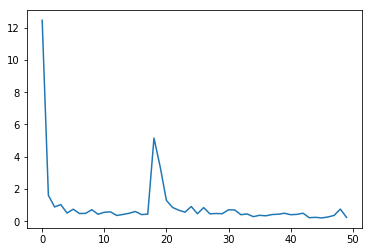

In [81]:
import matplotlib.pyplot as plt

print(total_evaluate())

plt.plot(all_losses)
plt.show()

In [82]:
all_categories = list(tag_to_ix)
n_categories = len(all_categories)

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories) 

with torch.no_grad():
    for i in range(len(test_data)):

        inputs = prepare_sequence(test_data[i][0], word_to_ix)
        output = model(inputs)

        # get top
        topv, topi = output.topk(1)
        true_values = prepare_sequence(test_data[i][1], tag_to_ix)
    
        for j in range(len(true_values)):
            confusion[true_values[j]][topi[j]] += 1 # инк ячейку
            
normalize_confusion = torch.clone(confusion)
# Normalize 
for i in range(n_categories):
    normalize_confusion[i] = normalize_confusion[i] / normalize_confusion[i].sum()

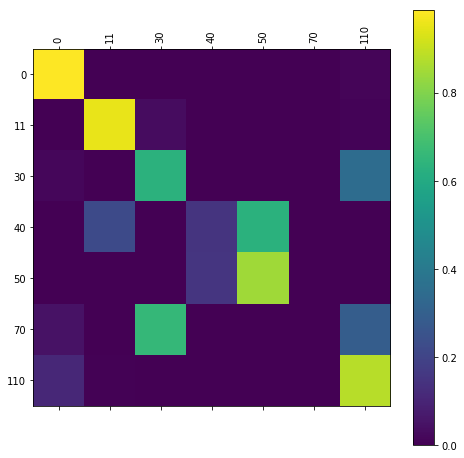

In [83]:
from matplotlib import ticker

# Set up plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(normalize_confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [84]:
all_perc = 0
for i in range(n_categories):
    
    percent = normalize_confusion[i][i][0]
    all_perc += percent
    
    print(normalize_confusion[i][i], confusion[i][i])
    
print(all_perc / (n_categories - 1))

tensor(0.9881) tensor(7643.)
tensor(0.9552) tensor(640.)
tensor(0.6349) tensor(40.)
tensor(0.1481) tensor(4.)
tensor(0.8462) tensor(11.)
tensor(0.) tensor(0.)
tensor(0.8805) tensor(766.)
tensor(0.7422)


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


# WITHout Attention

EMBEDDING_DIM = 64, HIDDEN_DIM = 128, SGD, 45k iterr, total_acc = 0.8931619994885903%

In [21]:
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
HIDDEN_DIM2 = 128

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, HIDDEN_DIM2, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()

all_losses = []

In [22]:
learning_rate = 0.1

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_iters = 5000

plot_every = 100
print_every = 250

current_loss = 0
#all_losses = []

start = time.time()

model.hidden1 = model.init_hidden1()
model.hidden2 = model.init_hidden2()


for i in range(1, n_iters + 1):
    
    se, tag = train_rng()
    out, loss = train(se, tag)
    current_loss += loss
    
    if i % print_every == 0:
        print('%d %d%% (%s) loss: %.4f accuracy on test: %.4f' % (i, i / n_iters * 100, 
                                                                  timeSince(start), loss, evaluate()))

    
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

250 5% (1m 19s) loss: 0.1246 accuracy on test: 0.9020
500 10% (2m 26s) loss: 0.0262 accuracy on test: 0.9468
750 15% (3m 14s) loss: 0.0419 accuracy on test: 0.9387
1000 20% (3m 54s) loss: 0.0112 accuracy on test: 0.9524
1250 25% (4m 40s) loss: 0.5620 accuracy on test: 0.9625
1500 30% (5m 30s) loss: 0.4535 accuracy on test: 0.9700
1750 35% (6m 21s) loss: 0.0521 accuracy on test: 0.9618
2000 40% (7m 11s) loss: 0.0239 accuracy on test: 0.9737
2250 45% (8m 9s) loss: 0.0743 accuracy on test: 0.9686
2500 50% (9m 11s) loss: 0.1413 accuracy on test: 0.9690
2750 55% (10m 6s) loss: 0.0078 accuracy on test: 0.9676
3000 60% (11m 4s) loss: 0.0097 accuracy on test: 0.9779
3250 65% (12m 5s) loss: 0.1801 accuracy on test: 0.9683
3500 70% (12m 57s) loss: 0.0017 accuracy on test: 0.9699
3750 75% (13m 53s) loss: 0.0217 accuracy on test: 0.9756
4000 80% (14m 57s) loss: 0.0130 accuracy on test: 0.9764
4250 85% (15m 48s) loss: 0.0947 accuracy on test: 0.9631
4500 90% (16m 51s) loss: 0.0179 accuracy on test:

0.9766864438396923


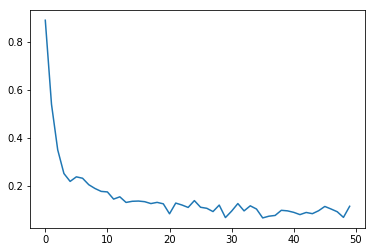

In [23]:
import matplotlib.pyplot as plt

print(total_evaluate())

plt.plot(all_losses)
plt.show()

In [32]:
learning_rate = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_iters = 3000

plot_every = 100
print_every = 250

current_loss = 0
#all_losses = []

start = time.time()

model.hidden1 = model.init_hidden1()
model.hidden2 = model.init_hidden2()


for i in range(1, n_iters + 1):
    
    se, tag = train_rng()
    out, loss = train(se, tag)
    current_loss += loss
    
    if i % print_every == 0:
        print('%d %d%% (%s) loss: %.4f accuracy on test: %.4f' % (i, i / n_iters * 100, 
                                                                  timeSince(start), loss, evaluate()))

    
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

250 8% (0m 25s) loss: 0.1714 accuracy on test: 0.9750
500 16% (0m 54s) loss: 0.0217 accuracy on test: 0.9824
750 25% (1m 27s) loss: 0.0075 accuracy on test: 0.9728
1000 33% (2m 5s) loss: 0.0636 accuracy on test: 0.9844
1250 41% (2m 58s) loss: 0.0395 accuracy on test: 0.9767
1500 50% (3m 49s) loss: 0.2232 accuracy on test: 0.9600
1750 58% (4m 35s) loss: 0.0117 accuracy on test: 0.9739
2000 66% (5m 23s) loss: 0.2220 accuracy on test: 0.9637
2250 75% (6m 14s) loss: 0.0140 accuracy on test: 0.9819
2500 83% (7m 6s) loss: 0.0078 accuracy on test: 0.9754
2750 91% (8m 5s) loss: 0.5167 accuracy on test: 0.9777
3000 100% (9m 2s) loss: 0.0059 accuracy on test: 0.9731


0.9771909739325662


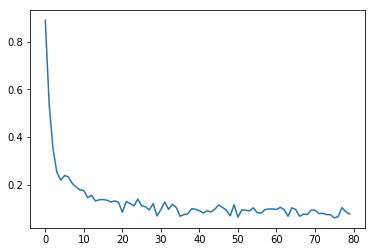

In [33]:
import matplotlib.pyplot as plt

print(total_evaluate())

plt.plot(all_losses)
plt.show()

## Save and load models

In [88]:
path = '../Models/LSTM_Tone_DUMA'

torch.save(model.state_dict(), path)

In [89]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, HIDDEN_DIM2, len(word_to_ix), len(tag_to_ix))
model.load_state_dict(torch.load(path))
model.eval()

LSTMTagger(
  (word_embeddings): Embedding(43502, 256)
  (lstm): LSTM(256, 256)
  (lstm2): LSTM(256, 128)
  (hidden2tag): Linear(in_features=128, out_features=7, bias=True)
)

## confusion matrix

In [28]:
all_categories = list(tag_to_ix)
n_categories = len(all_categories)

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories) 

n_confusion = 1000

with torch.no_grad():
    for i in range(len(test_data)):

        inputs = prepare_sequence(test_data[i][0], word_to_ix)
        output = model(inputs)

        # get top
        topv, topi = output.topk(1)
        true_values = prepare_sequence(test_data[i][1], tag_to_ix)
    
        for j in range(len(true_values)):
            confusion[true_values[j]][topi[j]] += 1 # инк ячейку
            
normalize_confusion = torch.clone(confusion)
# Normalize 
for i in range(n_categories):
    normalize_confusion[i] = normalize_confusion[i] / normalize_confusion[i].sum()

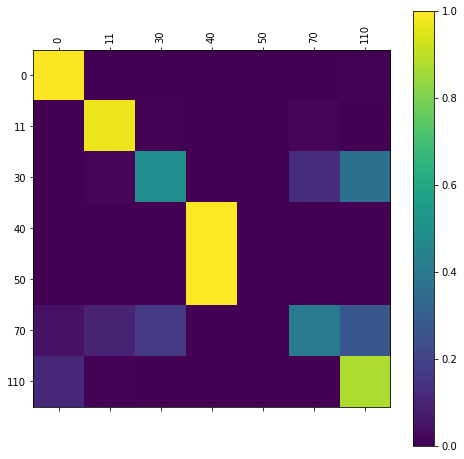

In [29]:
from matplotlib import ticker

# Set up plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(normalize_confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [30]:
tag_to_ix

{0: 0, 11: 1, 30: 2, 40: 3, 50: 4, 70: 5, 110: 6}

In [31]:
all_perc = 0
for i in range(n_categories):
    
    percent = normalize_confusion[i][i][0]
    all_perc += percent
    
    print(normalize_confusion[i][i], confusion[i][i])
    
print(all_perc / (n_categories - 1))

tensor(0.9951) tensor(7697.)
tensor(0.9746) tensor(653.)
tensor(0.4921) tensor(31.)
tensor(1.) tensor(27.)
tensor(0.) tensor(0.)
tensor(0.4146) tensor(17.)
tensor(0.8782) tensor(764.)
tensor(0.7924)


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [52]:
data[:5]

[(['уильям', 'дж', 'локк', '.'], [0, 0, 0, 11]),
 (['друг', 'человечества', '.'], [0, 0, 11]),
 (['один', '.'], [0, 11]),
 (['-',
   'мне',
   'нравится',
   'нунсмер',
   ',-',
   'сказал',
   'литератор',
   'из',
   'лондона',
   '.'],
  [0, 0, 0, 0, 11, 0, 0, 0, 0, 11]),
 (['-',
   'это',
   'место',
   ',',
   'куда',
   'складывают',
   'отцветшие',
   'жизни',
   ',',
   'пересыпая',
   'их',
   'лавандой',
   '.'],
  [0, 0, 0, 110, 0, 0, 0, 0, 110, 0, 0, 0, 11])]